# Mini-project 6.3 Customer segmentation with clustering

##Exploratory Data Analysis

In [ ]:
#Import the necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [ ]:
#import data with url link
df = pd.read_csv('https://github.com/FourthRevGitHub/CAM_DS_Public-Data-Sets/raw/main/Course%201/Week%206/CUSTOMERS_CLEAN.zip')

In [ ]:
#display the first few rows of data, and the shape to see num of rows and columns
pd.set_option('display.max_columns', None)
print(df.shape)
df.sample(5)

(951669, 20)


,Quantity,City,Continent,Postal_Code,State_Province,Order_Date,Delivery_Date,Total Revenue,Unit Cost,Discount,OrderTypeLabel,CustomerCountryLabel,Customer_BirthDate,Customer_Group,Customer_Type,Order ID,Profit,Days to Delivery,Loyalty Num,Customer ID
466348,2,Palermo,Europe,90141,Sicilia,03AUG2014,05AUG2014,$74.40,$36.90,.,Internet Sale,Italy,18FEB1978,Orion Club Gold members,Orion Club Gold members low activity,1236606711,$0.60,2,99,80726
34216,2,Paris,Europe,75338,Ile-de-France,30MAR2012,30MAR2012,$150.40,$75.40,.,Retail Sale,France,11AUG1983,Orion Club members,Orion Club members high activity,1230491059,($0.40),0,99,74202
577694,1,Clayton,North America,94517,California,21FEB2015,21FEB2015,$50.70,$46.20,.,Retail Sale,United States,17FEB1973,Orion Club members,Orion Club members medium activity,1238535299,$4.50,0,0,63904
782478,2,London,Europe,WC1E 7PH,City of London,03APR2016,03APR2016,$90.00,$38.40,.,Retail Sale,United Kingdom,24MAY1958,Orion Club Gold members,Orion Club Gold members high activity,1241883837,$13.20,0,0,16263
342039,1,Amsterdam,Europe,1096 AV,NaN,11JAN2014,11JAN2014,$41.40,$39.10,.,Retail Sale,Netherlands,09SEP1948,Orion Club Gold members,Orion Club Gold members medium activity,1234533978,$2.30,0,99,88007


In [ ]:
#determine metadata to look for nulls and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 951669 entries, 0 to 951668
Data columns (total 20 columns):
 #   Column                Non-Null Count   Dtype 
---  ------                --------------   ----- 
 0   Quantity              951669 non-null  int64 
 1   City                  951534 non-null  object
 2   Continent             951669 non-null  object
 3   Postal_Code           947953 non-null  object
 4   State_Province        834477 non-null  object
 5   Order_Date            951669 non-null  object
 6   Delivery_Date         951669 non-null  object
 7   Total Revenue         951669 non-null  object
 8   Unit Cost             951669 non-null  object
 9   Discount              951669 non-null  object
 10  OrderTypeLabel        951669 non-null  object
 11  CustomerCountryLabel  951669 non-null  object
 12  Customer_BirthDate    951669 non-null  object
 13  Customer_Group        951669 non-null  object
 14  Customer_Type         951669 non-null  object
 15  Order ID         

In [ ]:
#check for duplicate values
duplicate_counts = df.duplicated(keep=False).sum()
print('Duplicate rows:',duplicate_counts)
print('DF shape:',df.shape)
#observations should be unique per order, therefore drop duplicate values because they may skew data incorrectly
df.drop_duplicates(keep='first',inplace=True,ignore_index=True)
print('DF shape after removing duplicated rows:',df.shape)

Duplicate rows: 42
DF shape: (951669, 20)
DF shape after removing duplicated rows: (951648, 20)


In [ ]:
#as we are using unsupervised technique, we do not need labels, so remove unecessary columns
df = df.drop(['City','Continent','Postal_Code','State_Province','Order_Date','Discount','OrderTypeLabel','CustomerCountryLabel','Customer_Group','Customer_Type','Profit','Days to Delivery','Loyalty Num'],axis=1)
#change dates to datetime
df['Delivery_Date']=pd.to_datetime(df['Delivery_Date'],format='%d%b%Y')
df['Customer_BirthDate']=pd.to_datetime(df['Customer_BirthDate'],format='%d%b%Y')
#change $ values into float
for col in ['Unit Cost','Total Revenue']:
    df[col]=df[col].apply(lambda x: re.findall('\d+\.\d+', x)[0]).astype(float)
df['Total Cost']=df['Quantity']*df['Unit Cost']

In [ ]:
#check for null values now certain columns have been removed
for col in df.columns:
        print(col,':', df[col].isnull().sum() ,'null values')

Quantity : 0 null values
Delivery_Date : 0 null values
Total Revenue : 0 null values
Unit Cost : 0 null values
Customer_BirthDate : 0 null values
Order ID : 0 null values
Customer ID : 0 null values
Total Cost : 0 null values


In [ ]:
#create new features for frequency, age
df['Frequency'] = df.groupby('Customer ID')['Order ID'].transform('count')
df['Age'] = (pd.Timestamp('now')-df['Customer_BirthDate']).dt.days//365
df.drop(['Customer_BirthDate','Order ID','Unit Cost'],axis=1,inplace=True)

In [ ]:
#aggregate dataset to get one row per customer
df_agg = df.groupby('Customer ID').agg({
                                'Quantity':'sum',
                                'Total Revenue':'sum',
                                'Total Cost':'sum',
                                'Delivery_Date':'max',
                                'Frequency':'max',
                                'Age':'max'
                               }).reset_index()
df_agg['Recency']= (pd.to_datetime('today') - df_agg['Delivery_Date']).dt.days
#calculating the avg unit cost, because need to take quantity into account so to accurately represent distribution
df_agg['Avg Unit Cost']= df_agg['Total Cost']/df_agg['Quantity']
df_agg.rename(columns = {'Total Revenue':'CLV'},inplace=True)
#include customer id for analysis later on
df_agg_inc_id= df_agg.drop(['Delivery_Date','Quantity','Total Cost'],axis=1)
#dataset for models
df_agg.drop(['Customer ID','Delivery_Date','Quantity','Total Cost'],axis=1,inplace=True)
df_agg

,CLV,Frequency,Age,Recency,Avg Unit Cost
0,4322.70,35,71,3032,82.341176
1,2821.00,20,41,3134,96.160714
2,782.67,9,41,4123,39.528235
3,2810.98,19,36,3020,89.086207
4,1604.58,15,66,3205,55.000000
...,...,...,...,...,...
68295,982.47,6,41,3769,86.992308
68296,927.78,4,27,3934,115.075000
68297,6311.27,49,51,3062,93.729348
68298,1453.20,8,57,3358,88.664286


In [ ]:
#calculate descriptive stats with columns that will be used
df_agg.describe().round()

,CLV,Frequency,Age,Recency,Avg Unit Cost
count,68300.0,68300.0,68300.0,68300.0,68300.0
mean,1821.0,14.0,51.0,3381.0,79.0
std,1562.0,11.0,17.0,414.0,39.0
min,1.0,1.0,27.0,2995.0,0.0
25%,678.0,6.0,36.0,3059.0,56.0
50%,1428.0,11.0,51.0,3203.0,73.0
75%,2529.0,19.0,66.0,3553.0,93.0
max,17861.0,121.0,82.0,4839.0,936.0


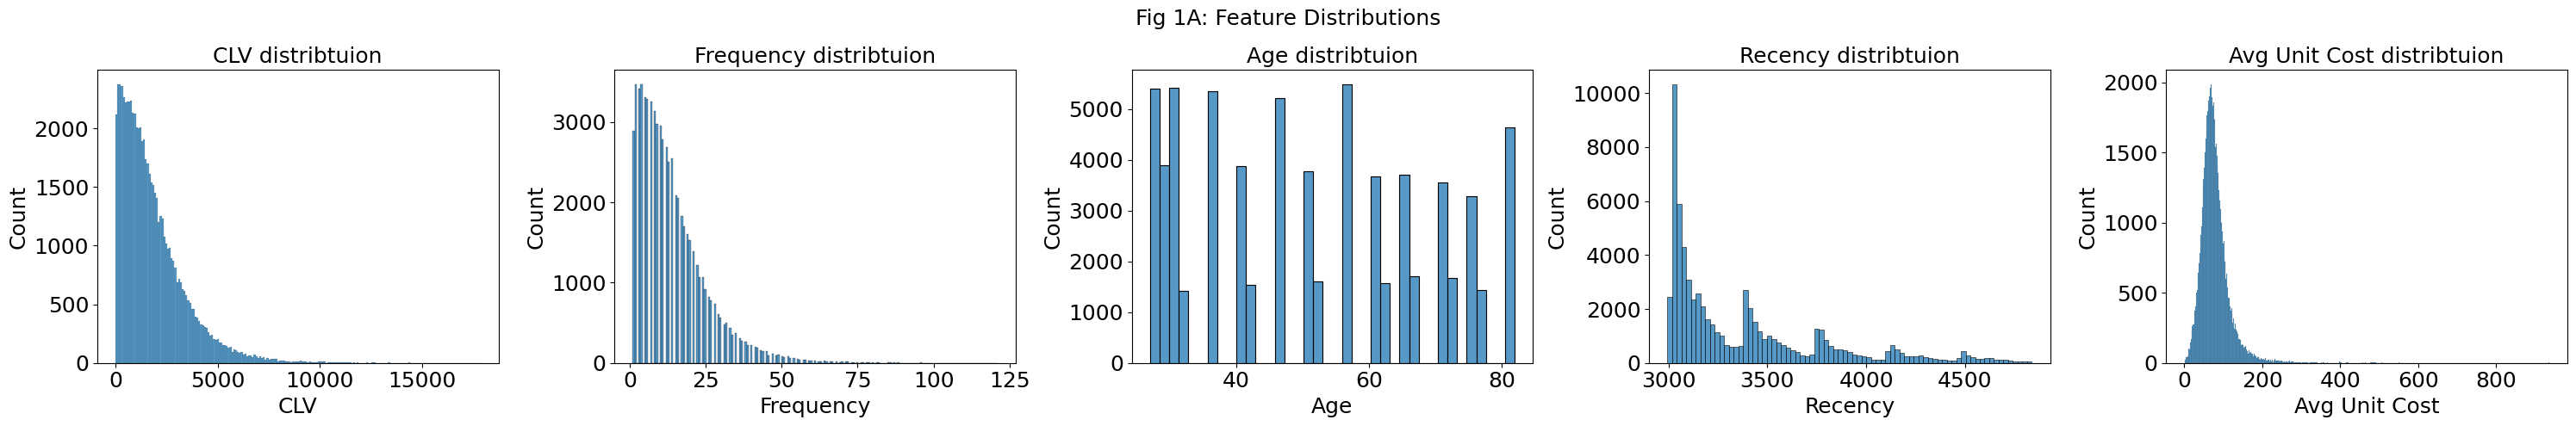

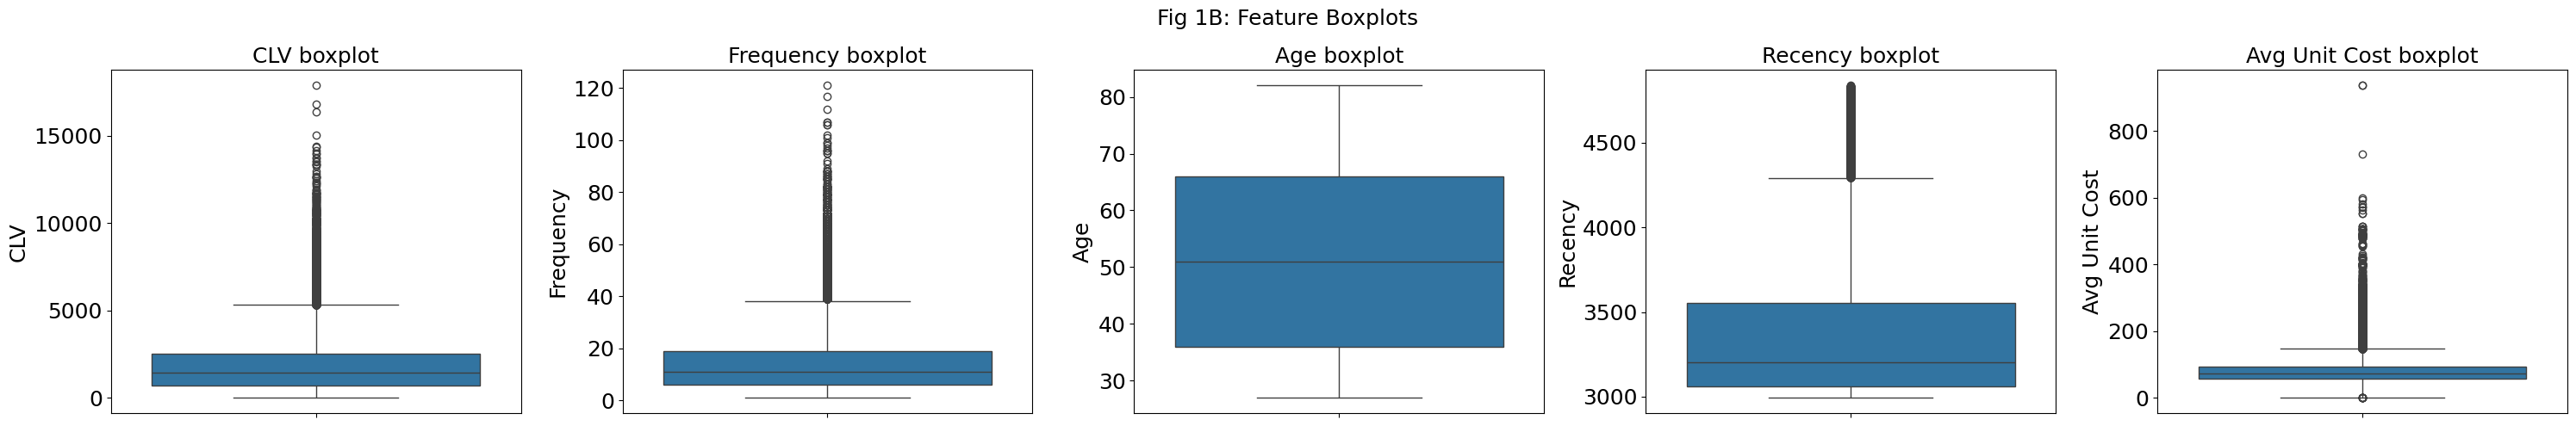

In [ ]:
#check the distribution of the data, and check for any initial outliers
fig, axes = plt.subplots(1, len(df_agg.columns), figsize=(16,4))
j=0
for feature in list(df_agg.columns):
    sns.histplot(df_agg[feature], ax =axes[j])
    axes[j].set_title(f"{feature} distribtuion",fontsize=18)
    axes[j].set_xlabel(f"{feature}", fontsize=18)
    axes[j].set_ylabel('Count', fontsize=18)
    axes[j].tick_params(axis='x', labelsize=18)
    axes[j].tick_params(axis='y', labelsize=18)
    fig.suptitle('Fig 1A: Feature Distributions',fontsize=18)
    fig.set_size_inches(30,5)
    plt.tight_layout()
    j+=1

fig, axes = plt.subplots(1, len(df_agg.columns), figsize=(16,4))
j=0
for feature in list(df_agg.columns):
    sns.boxplot(df_agg[feature], ax =axes[j])
    axes[j].set_title(f"{feature} boxplot", fontsize=18)
    axes[j].set_ylabel(f"{feature}", fontsize=18)
    axes[j].tick_params(axis='x', labelsize=18)
    axes[j].tick_params(axis='y', labelsize=18)
    fig.suptitle('Fig 1B: Feature Boxplots',fontsize=18)
    fig.set_size_inches(30,5)
    plt.tight_layout()
    j+=1

###42 duplicate values have been removed from the dataset. There were null values present, though in columns that are not used, therefore will not affect this analysis. 5 new features were created to identify attributes/ behaviour of clients, aggregated to create one row per customer. Several outliers are present, however they have not been removed as they may be informative, and are large in number.

##K-means with elbow method

In [ ]:
#will need a scaled dataset for clustering methods
#use column transformer and pipeline for increased efficiency
preprocessor = ColumnTransformer(
    transformers=[
        ('num',StandardScaler(),list(df_agg.columns))])
df_agg_scaled = preprocessor.fit_transform(df_agg)
#create funciton to calculate inertia values and cluster labels for kmeans
def kmeans(n_clusters):
    kmeans= KMeans(n_clusters=n_clusters, init='k-means++',random_state=10,n_init = 3)
    pipeline = Pipeline(steps=[('preprocessor',preprocessor)
                                ,('clusterer', kmeans)])
    cluster_labels = pipeline.fit_predict(df_agg)
    inertia = round(pipeline.named_steps['clusterer'].inertia_)
    return cluster_labels,inertia

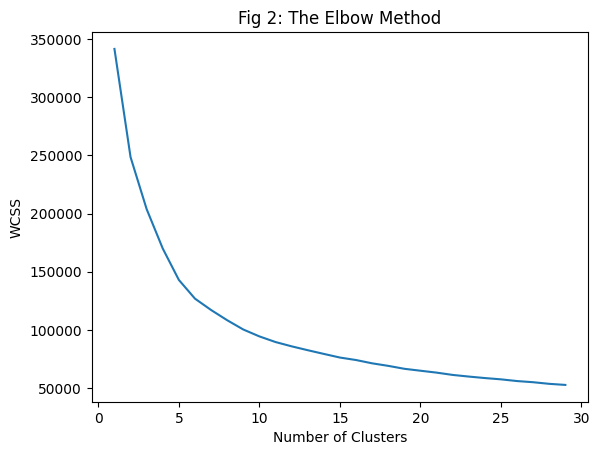

In [ ]:
#create a dataset of inertia values for varying cluster numbers
wcss=[]
for i in range(1,30):
    wcss.append(kmeans(i)[1])
#plot inertia values to visualise using elbow method
plt.plot(range(1,30),wcss)
plt.title('Fig 2: The Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

###There is no distinct 'elbow point' in the resutls , making it unclear as to the optimal number of clusters. The WCSS values remain high for a large number of clusters

##K-means with silhouette score

In [ ]:
#calculate the silhouette score for 2-7 clusters
for i in range(2,8):
    silhouette_avg = round(silhouette_score(df_agg_scaled, kmeans(i)[0]),2)
    print("For n_clusters =", i,
            "The average silhouette_score is:", silhouette_avg)

For n_clusters = 2 The average silhouette_score is: 0.26
For n_clusters = 3 The average silhouette_score is: 0.25
For n_clusters = 4 The average silhouette_score is: 0.25
For n_clusters = 5 The average silhouette_score is: 0.27
For n_clusters = 6 The average silhouette_score is: 0.25
For n_clusters = 7 The average silhouette_score is: 0.24


###The silhouette score was computationally very intensive. Values do not appear to change much when varying the number of clusters. A coefficient of 1 signifies a very good fit, therefore these values are fairly low, and indicate room for improvement on quality of clustering.

##Visualising kmeans with PCA

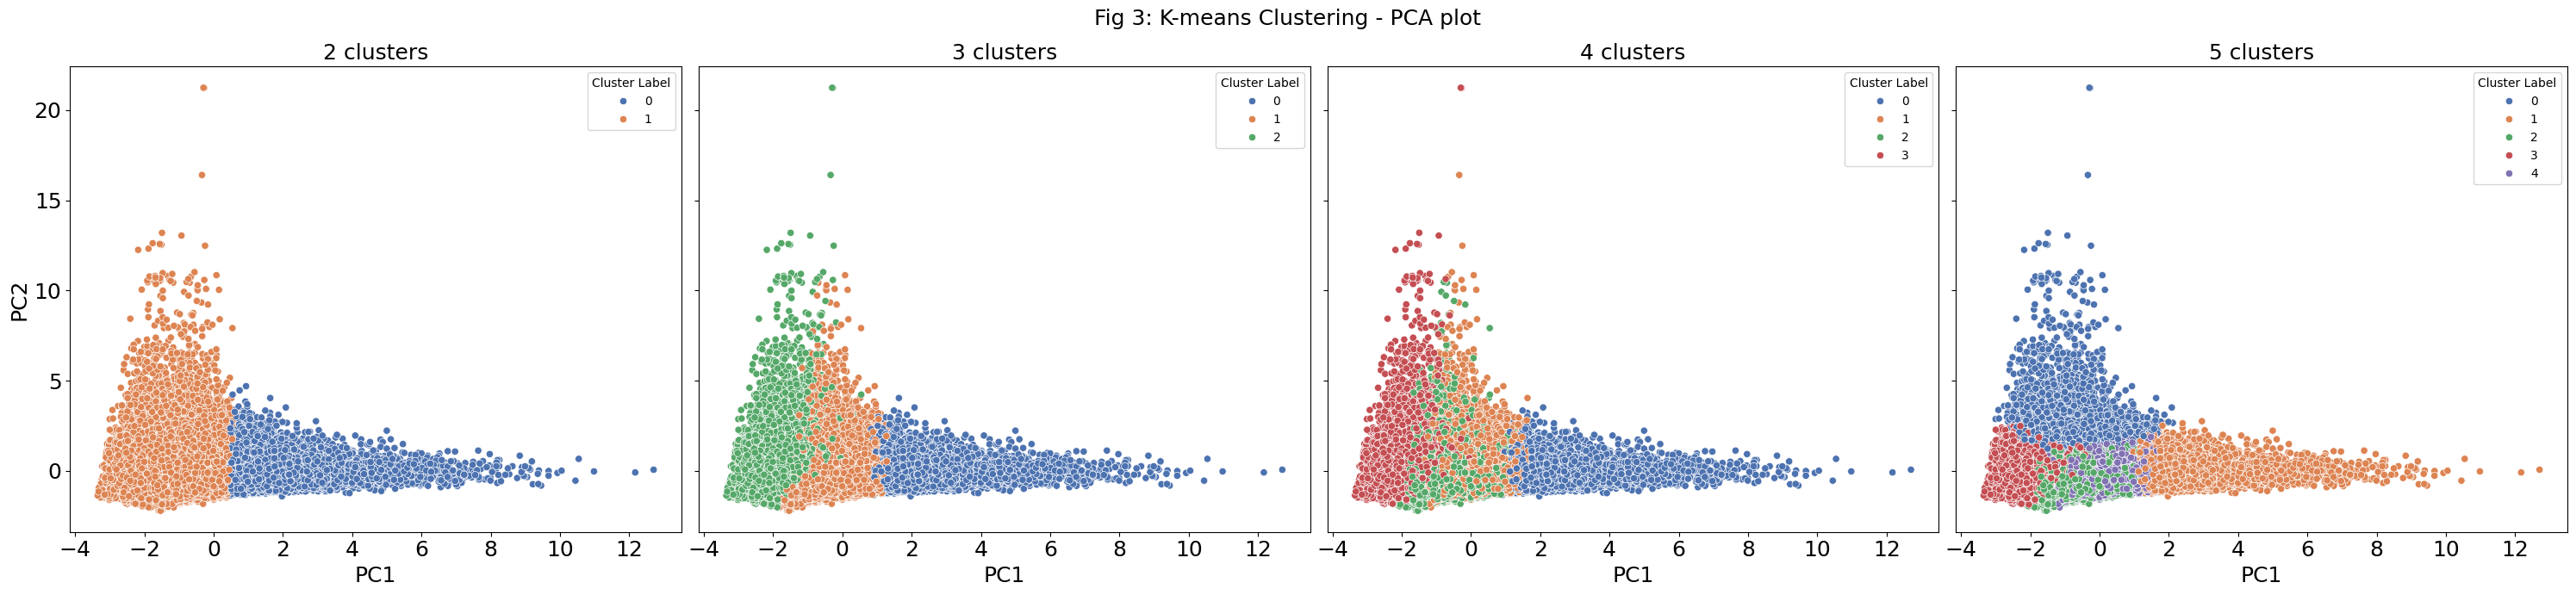

In [ ]:
#use pca to visualise data - this time on whole dataset
pca = PCA(n_components=2)
df_pca = pd.DataFrame(pca.fit_transform(df_agg_scaled))
fig, axes = plt.subplots(1, 4, figsize=(30,5),sharey=True)
j = 0
for i in range(2,6):
    cluster_labels = pd.DataFrame(kmeans(i)[0])
    #merge the pca data frame with the cluster labels produced by kmeans
    df_pca_clust_labels = pd.merge(df_pca,cluster_labels, left_index=True, right_index=True)
    df_pca_clust_labels.columns=['PC1','PC2','Cluster Label']
    g=sns.scatterplot(
            x=df_pca_clust_labels['PC1'],
            y=df_pca_clust_labels['PC2'],
            hue= df_pca_clust_labels['Cluster Label'],
            ax=axes[j],
            palette='deep')
    axes[j].set_ylabel('PC2',fontsize=18)
    axes[j].tick_params(axis='x', labelsize=18)
    axes[j].tick_params(axis='y', labelsize=18)
    axes[j].set_xlabel('PC1',fontsize=18)
    axes[j].set_title(f'{i} clusters',fontsize=18)
    fig.set_size_inches(30,7)
    j+=1
plt.suptitle('Fig 3: K-means Clustering - PCA plot',fontsize = 18)
plt.tight_layout()

###3 clusters appears to be the most coherent grouping, when using 4 or 5 there are soft clusters with significant overlapping of data points

##Dendrogram & agglomerative hierarchical clustering

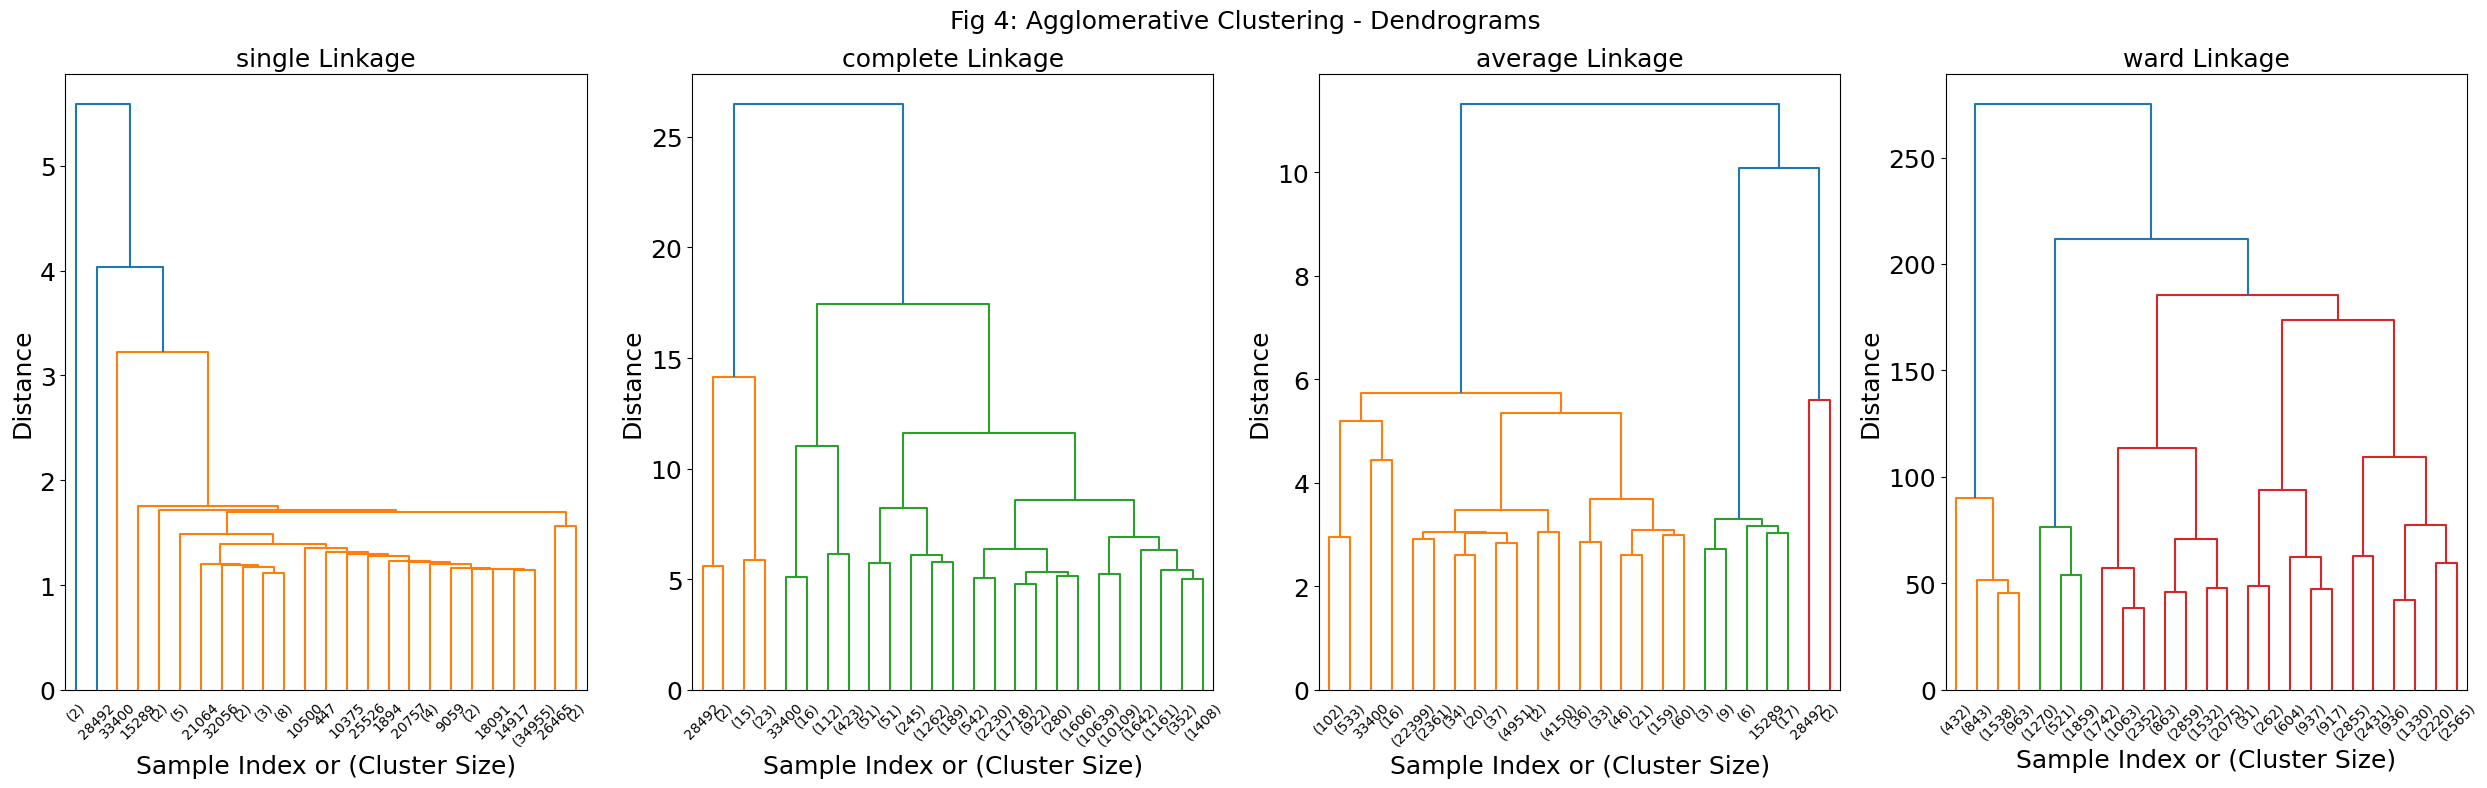

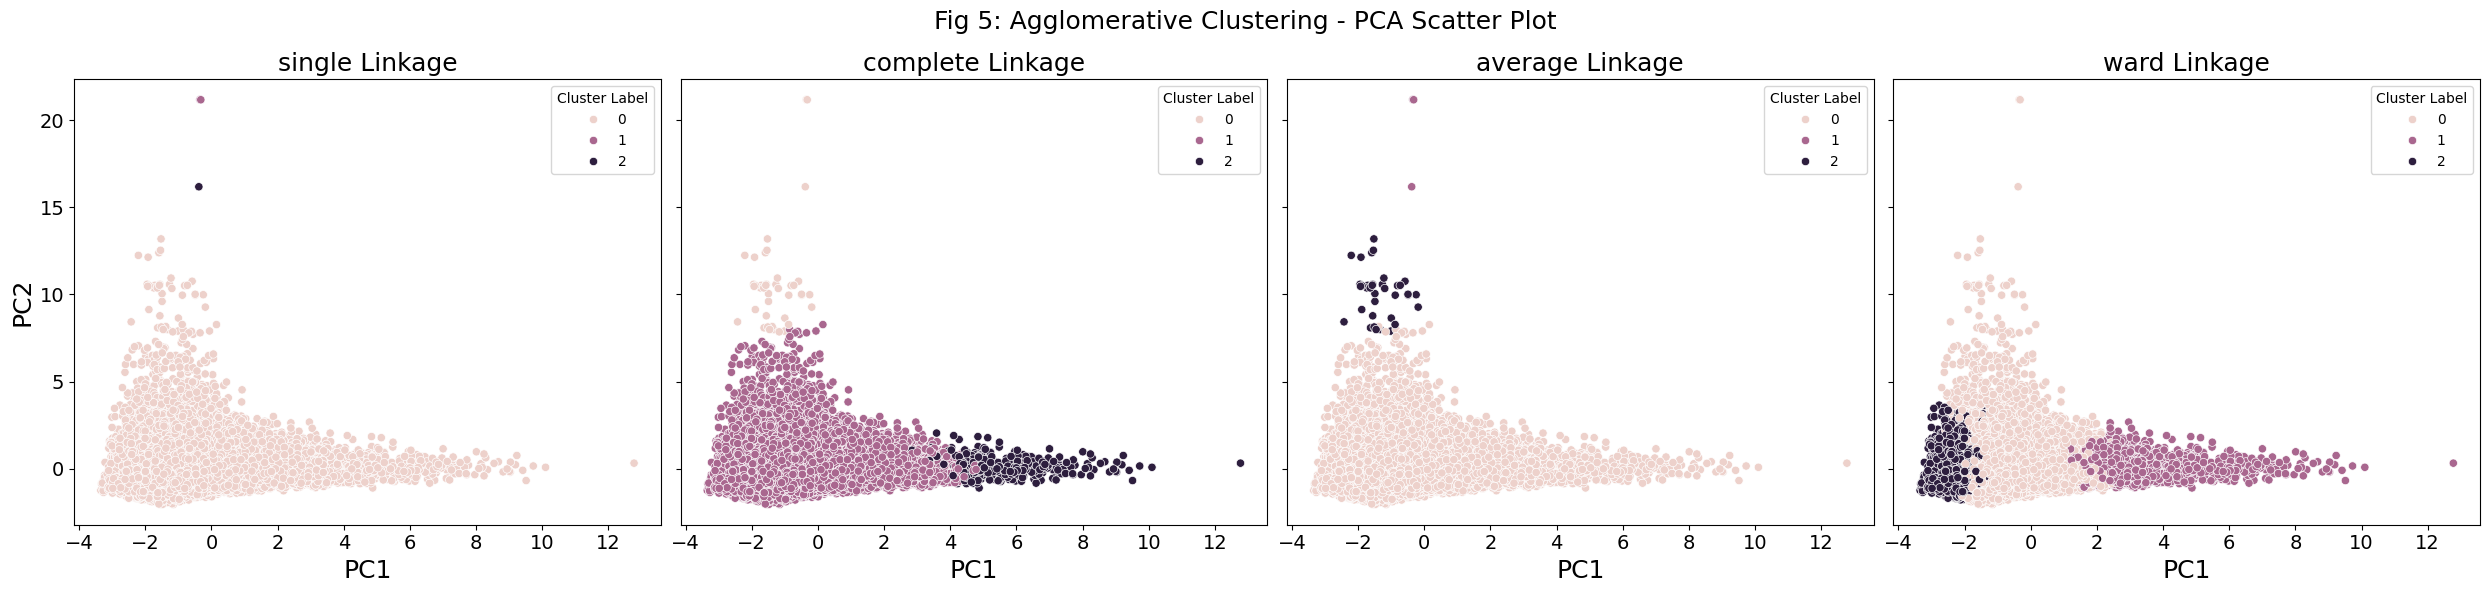

In [ ]:
# use pca and dendrograms to visualise the different linkage methods, and cluster formations
# using a sample of data as laptop was crashing
small_df = df_agg.sample(n=30000).reset_index(drop=True)
sample_df = pd.DataFrame(preprocessor.fit_transform(small_df),columns=small_df.columns)
pca = PCA(n_components=2)
df_sample_pca = pd.DataFrame(pca.fit_transform(sample_df))
df_agg_pca = pd.DataFrame(pca.fit_transform(df_agg_scaled))

#function for plotting dendrogram
def plot_dendrogram(X,method, ax):
    linked = linkage(X, method=method)
    dendrogram(linked, ax=ax, truncate_mode = 'lastp',p=25)
    ax.set_title(f'{i} Linkage',fontsize=18)

#function for visualing PCA with agglomerative clustering
def plot_scatterplot(method,ax):
    agglo_cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage=method)
    agglo_cluster_label= pd.DataFrame(agglo_cluster.fit_predict(sample_df))
    df_sample_pca_clust_labels = pd.merge(df_sample_pca,agglo_cluster_label, left_index=True, right_index=True)
    df_sample_pca_clust_labels.columns=['PC1','PC2','Cluster Label']
    sns.scatterplot(x=df_sample_pca_clust_labels['PC1'],y=df_sample_pca_clust_labels['PC2'],hue= df_sample_pca_clust_labels['Cluster Label'],ax=ax)
    ax.set_title(f'{i} Linkage',fontsize = 18)

# test different linkage methods
linkage_methods = ['single', 'complete', 'average', 'ward']
fig, axes = plt.subplots(1, 4, figsize=(25, 8))
j=0
for i in linkage_methods:
    plot_dendrogram(sample_df,method = i, ax = axes[j])
    axes[j].set_ylabel('Distance',fontsize=18)
    axes[j].set_xlabel('Sample Index or (Cluster Size)',fontsize=18)
    axes[j].tick_params(axis='y', labelsize=18)
    j+=1
plt.suptitle('Fig 4: Agglomerative Clustering - Dendrograms',fontsize = 18)
plt.tight_layout()
fig, axes = plt.subplots(1, 4, figsize=(25, 6),sharey=True)
j=0
for i in linkage_methods:
    plot_scatterplot(method = i, ax = axes[j])
    axes[j].set_ylabel('PC2',fontsize=18)
    axes[j].set_xlabel('PC1',fontsize=18)
    axes[j].tick_params(axis='x', labelsize=14)
    axes[j].tick_params(axis='y', labelsize=14)
    j+=1
plt.suptitle('Fig 5: Agglomerative Clustering - PCA Scatter Plot',fontsize = 18)
plt.tight_layout()

###There is a significant difference in the allocation of clusters given the different linkage methods. Single and average appear to isolate specific anomalies, where ward and complete includes them in a larger group. Dendrograms are very subjective, which makes finding an optimal number of clusters less quantitative. For example there may be an argument to use 4/5 clusters when looking at ward given the short distance to merge.

###Note: Because this process was causing my laptop to crash a sample was used, which may not accurately represent the underlying data.

##Running Kmeans with 3 clusters

In [ ]:
#choosing k and running kmeans with 3 clusters
cluster_labels = pd.DataFrame(kmeans(3)[0])
#join cluter labels to each individual customer ID
df_clust_labels = pd.merge(df_agg_inc_id,cluster_labels, left_index=True, right_index=True)
df_clust_labels.rename(columns={0:'Cluster Label'},inplace=True)
df_clust_labels[['Customer ID','Cluster Label']]

,Customer ID,Cluster Label
0,1,0
1,3,1
2,4,2
3,5,1
4,6,1
...,...,...
68295,94248,2
68296,94250,2
68297,94252,0
68298,94253,1


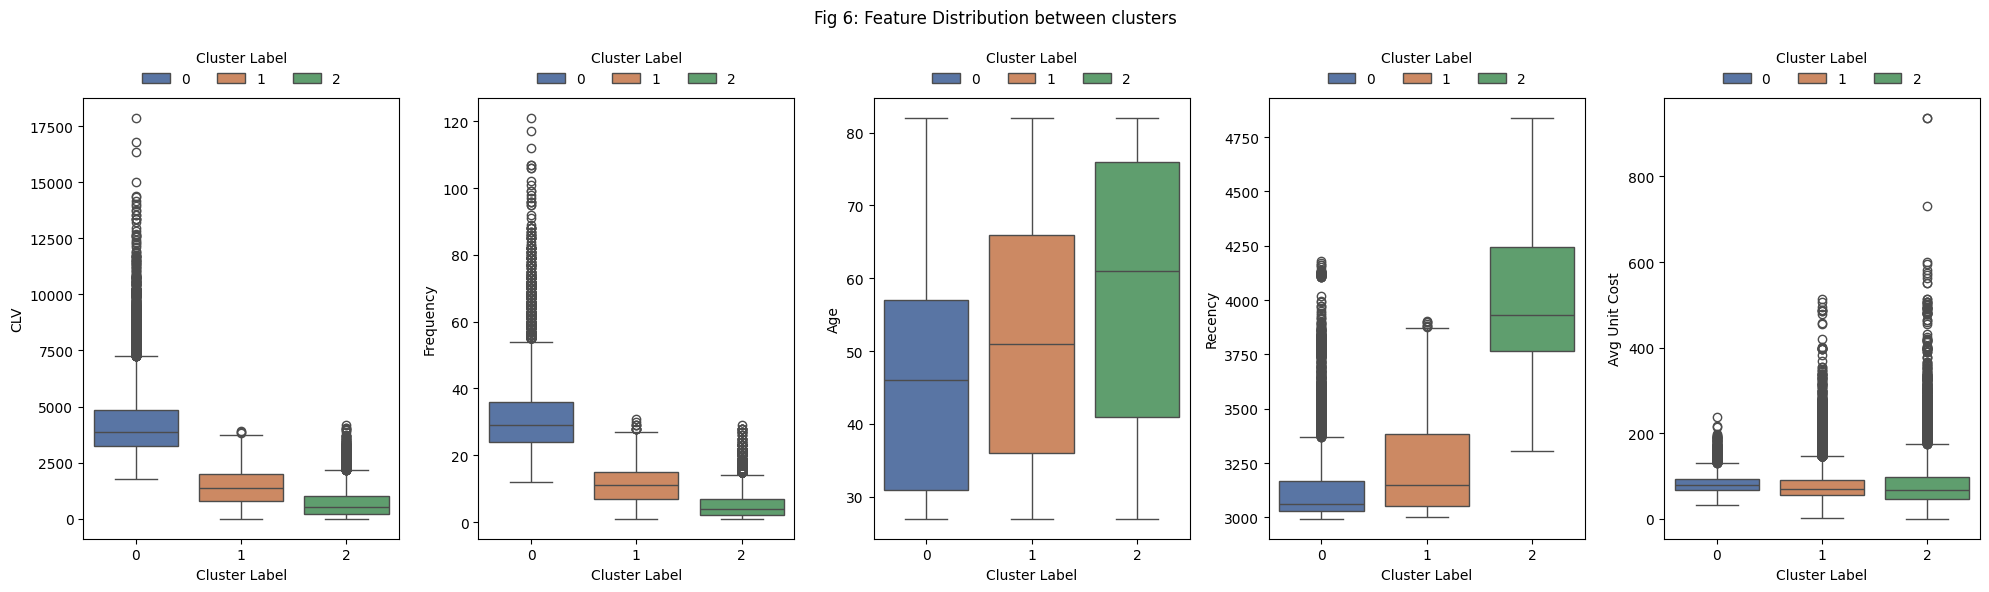

In [ ]:
#visualise clusters with respect to features in the dataset
fig, axes = plt.subplots(1, len(list(df_agg.columns)), figsize=(20,6))
j = 0
for feature in list(df_agg.columns):
    g = sns.boxplot(data=df_clust_labels, x='Cluster Label', y = feature,hue ='Cluster Label',ax = axes[j],palette='deep')
    sns.move_legend(
    axes[j], "lower center",
    bbox_to_anchor=(.5, 1), ncol=3,  frameon=False,
    )
    j+=1
plt.suptitle('Fig 6: Feature Distribution between clusters')
plt.tight_layout()
plt.show()

###3 clusters were used for kmeans as the results from the PCA scatter plot show the most defined cluster boundaries. The distribution of feature values between clusters varies significantly as can be seen above, with several outliers present.

##Visualise kmeans using t-SNE

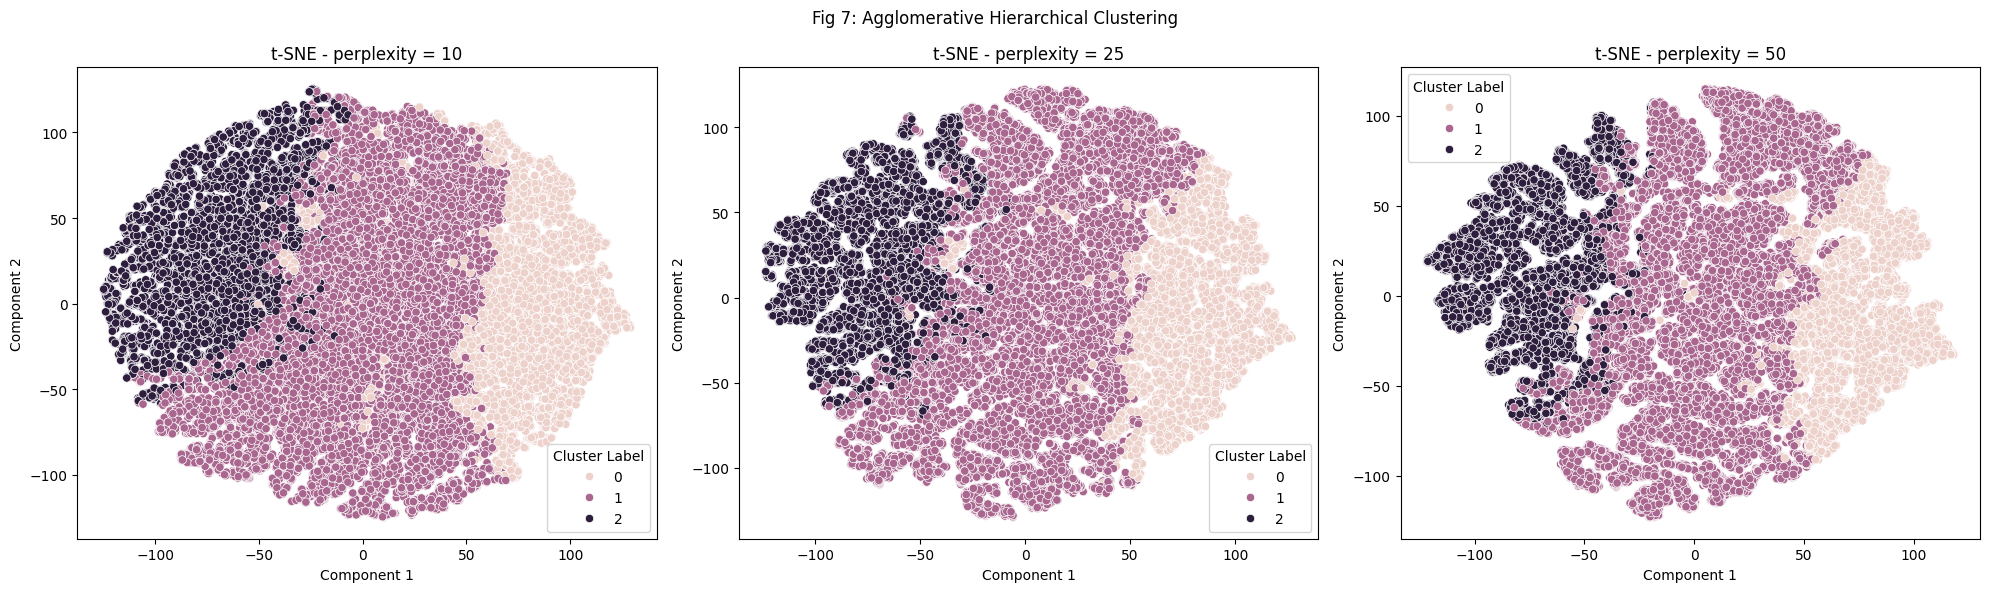

In [ ]:
#trial varying perplexity levels
perplexity = [10,25,50]
fig, axes = plt.subplots(1, len(list(perplexity)), figsize=(20,6))
j = 0
for p in perplexity:
    #reduce to 2 dimensions using t-sne
    tsne = TSNE(n_components=2, perplexity=p, random_state =10)
    TSNE_transformed_data = pd.DataFrame(tsne.fit_transform(df_agg_scaled))
    df_tsne_clust_labels = pd.merge(TSNE_transformed_data,cluster_labels, left_index=True, right_index=True)
    df_tsne_clust_labels.columns=['Component 1','Component 2','Cluster Label']
    # Visualise the perplexity data.
    sns.scatterplot(
        x=df_tsne_clust_labels['Component 1'],
        y=df_tsne_clust_labels['Component 2'],
        hue= df_tsne_clust_labels['Cluster Label'],
        ax = axes[j])
    axes[j].set_title(f't-SNE - perplexity = {p}')
    j+=1
plt.suptitle('Fig 7: Agglomerative Hierarchical Clustering')
plt.tight_layout()
plt.show()

###This was extremely computationally intensive, and took a long time to run. The lower perplexities show sub clusters forming, however at such a low perplexity it is difficult to know whether this ignores the broader context.

### Reference:
SAS, 2024. CUSTOMERS_CLEAN [Data set]. SAS. Last revised on 15 December 2021. [Accessed 20 February 2024].